# Summary of Learned Concepts in CAP 4630 - Neural Networks
This will look into the structure, components, and compilation of neural network models.

In [0]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
from matplotlib import cm, image as mpimg, pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers

## The Building Blocks

Before the specifics of convolutional neural networks are discussed, it is important to build the foundation of how deep learning models are composed. Some of the building blocks were covered in the "Logistic Regression" section of [this notebook](https://colab.research.google.com/drive/1yiKD6zkVoJvzw_otkzvkzDD6BrkIdqDS#scrollTo=84lLu78IQwVy "BasicConcepts - Google Colab"), so no further explanations will be given on those.

### The Layer

A layer is any structure that takes in some input *tensor*, which can naively be thought as the multidimensional generalization of matrices, and outputs a different tensor. These layers may hold some data that serves as *memory*, but this is not required (for instance, *flatten* layers vectorize the input tensor, and thus do not require any memory).

These layers are combined with one another, such that the output of one layer becomes the input of the next. The easiest model for this is a *sequential* model, where there is a linear path through the set of all layers. More complicated networks may require the use of a more complicated ordering of layers, such as *two-branch*, *multihead networks*, and the inclusion of *inception blocks*.

The following shows a logistic network that is implemented using layers.

In [0]:
def keras_create_logistic_model ():
  # Defines the model
  logistic_network = models.Sequential()
  # Adds a single dense layer
  logistic_network.add(layers.Dense(1, activation='sigmoid', input_shape=(2,)))
  # Compiles the network
  logistic_network.compile(optimizer='rmsprop',
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
  return logistic_network

### The Optimizer

Notice how in the above model includes an "optimizer" in the compilation of the model. The optimizer is what determines the updating of the model, based off of the loss function.

## Convolutional Neural Networks

A convolutional neural network (CNN) is a specific deep learning model that, over time, aabstracts information about the input tensor across the layers in the network. The *convolution* operator for a convolution module takes a kernel and passes it over the input to extract features from it. For example, here is a convolution implementation for 2D tensors (matrices).

In [0]:
def conv2d (input_mat, kernel_mat, stride = 1):
  # Tests if arrays are of proper form
  try:
    im = np.array(input_mat)
    x,y = im.shape
  except:
    raise Exception('Input could not be coerced into a 2D numpy array.')
  try:
    km = np.array(kernel_mat)
    u,v = km.shape
  except:
    raise Exception('Kernel could not be coerced into a 2D numpy array.')
  # Tests if arrays are of proper size
  if x != y:
    raise Exception(("Input is expected to be an (n,n) matrix. "
                    "Instead got a matrix of shape ({0},{1}).").format(x, y))
  if u != v:
    raise Exception(("Kernel is expected to be an (n,n) matrix. "
                    "Instead got a matrix of shape ({0},{1}).").format(u, v))
  # Tests if the input is smaller than the kernel
  if x < u:
    raise Exception(("Kernel is too large. Expected kernel of shape "
                    "(n,n), where n <= {0}. Instead got n = {1}.").format(x, u))
  # Checks stride
  if stride < 1 or stride - int(stride) != 0:
    raise Exception('Stride must a positive integer.')

  # Mirrors the kernel for faster convolution
  km_mirror = np.fliplr(np.flipud(km))

  # Creates the output matrix
  output_size = np.ceil((x-u+1)/stride).astype(int)
  output_mat = np.zeros(shape=(output_size, output_size))

  # Performs convolution
  for i in range(output_size):
    si = stride * i
    for j in range(output_size):
      sj = stride * j
      output_mat[i,j] = np.sum(np.multiply(im[si:u+si,sj:u+sj], km_mirror))
  
  return output_mat

*ReLU* (Rectified Linear Unit) is then performed on the output of the feature map, which sets all negative values to 0:

$$ReLU(x)= \begin{cases}
x, & \text{if $x>0$}\\
0, & \text{otherwise} \end{cases}$$

Training all the weights for convolution takes a lot of time, so adding a layer that reduces the amount of parameters to train would be ideal. This is the function of the *max pooling* layer. It strides over the *feature map* (the output of a convolutional block) and only takes the largest values. The following is another implementation for 2D tensors.

In [0]:
def maxpooling2d (input_mat, s):
  # Tests if array is of proper form
  try:
    im = np.array(input_mat)
    x,y = im.shape
  except:
    raise Exception('Input could not be coerced into a 2D numpy array.')
  # Tests if array is of proper size
  if x != y:
    raise Exception(("Input is expected to be an (n,n) matrix. "
                    "Instead got a matrix of shape ({0},{1}).").format(x, y))
  # Tests if the input is smaller than the window
  if x < s:
    raise Exception(("Window is too large. Expected window of shape "
                    "(n,n), where n <= {0}. Instead got n = {1}.").format(x, s))

  # Creates the output matrix
  output_size = np.ceil((x-s+1)/s).astype(int)
  output_mat = np.zeros(shape=(output_size, output_size))

  # Performs max pooling
  for i in range(output_size):
    si = s * i
    for j in range(output_size):
      sj = s * j
      output_mat[i,j] = np.max(im[si:s+si,sj:s+sj])
  
  return output_mat

Finally, there is a classifier, which is composed of *fully connected* layers. In these, all nodes between two layers are connected to one another.

Let's see what a convolutional neural network looks like in *Keras*:

In [0]:
# Constructs the neural network model according to the specifications given
model = models.Sequential()

# Adds the layers to the model. Also specifies the size of the input data on the first layer
model.add(layers.Conv2D(32, (5, 5), activation='relu', strides=1,
                        padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D((2, 2), strides=2))

model.add(layers.Conv2D(32, (5, 5), activation='relu', strides=1))
model.add(layers.MaxPool2D((2, 2), strides=2))

model.add(layers.Conv2D(64, (5, 5), activation='relu', strides=1))
model.add(layers.MaxPool2D((2, 2), strides=2))

# Flatten the layers before adding final fully-connected layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Compiles the model using cross entropy (categorial as multi-class)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

We can train this model on the CIFAR-10 dataset.

In [57]:
# Loads in CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Normalize the data (Easier training)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255
# Flattens the labels
y_train = y_train.flatten()
y_test = y_test.flatten()
# Defines the size of each set
# (Note: normally, these subsets would be chosen randomly, but this only uses
# the first n elements from each set for simplicity)
train_size = 1600
test_size = 400

model.fit(x_train[:train_size], y_train[:train_size], epochs=5,
          validation_data=(x_test[:test_size], y_test[:test_size]))

Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/step - loss: 2.2603 - accuracy: 0.1350 - val_loss: 2.1003 - val_accuracy: 0.2550
Epoch 2/5
1600/1600 [==============================] - 3s 2ms/step - loss: 2.0946 - accuracy: 0.2519 - val_loss: 2.1192 - val_accuracy: 0.2625
Epoch 3/5
1600/1600 [==============================] - 3s 2ms/step - loss: 1.9581 - accuracy: 0.2881 - val_loss: 1.8287 - val_accuracy: 0.3500
Epoch 4/5
1600/1600 [==============================] - 3s 2ms/step - loss: 1.8100 - accuracy: 0.3281 - val_loss: 1.8991 - val_accuracy: 0.2950
Epoch 5/5
1600/1600 [==============================] - 3s 2ms/step - loss: 1.7351 - accuracy: 0.3756 - val_loss: 1.7618 - val_accuracy: 0.3500


Now, we can view a confusion matrix and see the results of the traning of the model:



Confusion Matrix:


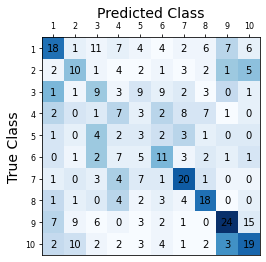

Class  1  has accuracy:  51.43 %
Class  2  has accuracy:  30.3 %
Class  3  has accuracy:  23.08 %
Class  4  has accuracy:  17.5 %
Class  5  has accuracy:  7.32 %
Class  6  has accuracy:  28.21 %
Class  7  has accuracy:  42.55 %
Class  8  has accuracy:  42.86 %
Class  9  has accuracy:  64.86 %
Class  10  has accuracy:  40.43 %


In [58]:
# Prints the accuracy for each class from the confusion matrix
def print_accuracy(matrix):
    i, j = matrix.shape
    if i != j:
        print('Confusion Matrix must be nxn')
        return
    for row in range(i):
        total = np.sum(matrix[row])
        percent = (matrix[row][row] / total) * 100
        print('Class ', row+1, ' has accuracy: ', round(percent, 2), '%')
    return

# Gets the confusion matrix
class_predictions = model.predict_classes(x_test[test_size:2*test_size])

confusion_matrix = tf.math.confusion_matrix(labels=y_test[test_size:2*test_size],
                                            predictions=class_predictions).numpy()

# Prints the confusion matrix
print("\n\nConfusion Matrix:")
fig, ax = plt.subplots()
ax.imshow(confusion_matrix, cmap='Blues')
s = confusion_matrix.shape[0]
for i in range(s):
    for j in range(s):
        c = int(confusion_matrix[i,j])
        ax.text(i, j, str(c), va='center', ha='center')
ax.set_xlabel('Predicted Class')
ax.xaxis.set_label_position('top') 
ax.set_ylabel('True Class')
ax.set_xticks(np.arange(s))
ax.set_xticklabels(np.arange(1,s+1))
ax.xaxis.tick_top()
ax.set_yticks(np.arange(s))
ax.set_yticklabels(np.arange(1,s+1))
plt.show()

# Prints the accuracy of the confusion matrix
print_accuracy(confusion_matrix)

Comparing this to FLDF from [this notebook](https://colab.research.google.com/drive/1gm1xO1u1yHFSCzDo7pqL11cOl4Uwbte1#scrollTo=prLt_tYQCCci "General Concepts - Python Notebook"), we can see the difference that even an extremely simple neural network can have on the performance of the model.